<a href="https://colab.research.google.com/github/KOdin2/machine_learning/blob/main/Random_forest_assessment_with_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Random forest**

This code up is used to classify a dataset whose labels are a binary (either 1 and 0) a range of hyperparameters are tried. The best hyperparameters are used to calculate the Gini importance of each feature. The Gini importance allows us to remove features with a rank of 0, which means the model does not find it useful.

**Note:** A uploaded dataset must have one column labeled "Label" with the row values as a 1 or 0 otherwise this code will not work

In [ ]:
#Import libraries
import matplotlib.pyplot as plt
import numpy as np
import io
import pandas as pd
import sklearn
import csv


#import functions from SKlearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

The following code is used to upload as many files as you want to be classified

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Aluminium_3-8Zor_ffs_dataset.csv to Aluminium_3-8Zor_ffs_dataset (2).csv
Saving Aluminium_8-25WF_ffs_dataset.csv to Aluminium_8-25WF_ffs_dataset (2).csv
Saving Aluminium_25-75WF_dataset.csv to Aluminium_25-75WF_dataset (2).csv
Saving Aluminium_FM_dataset.csv to Aluminium_FM_dataset (2).csv
Saving Brass_3-8Zor_ffs_dataset.csv to Brass_3-8Zor_ffs_dataset (2).csv
Saving Brass_BIM_dataset.csv to Brass_BIM_dataset (2).csv
Saving SSteel_8-25Zur_datset.csv to SSteel_8-25Zur_datset (3).csv
Saving SSteel_25-75WF_dataset.csv to SSteel_25-75WF_dataset (2).csv
Saving Zinc_8-25WF_ffs_dataset.csv to Zinc_8-25WF_ffs_dataset (2).csv


The best measurements to use for classification are:

* precision
* recall
* accuracy
* f1
* roc_auc

Be careful with precision and recall as you can achieve 100% of one and have a really low other. F1 score is the harmoninc mean of precision and recall therefore should be used instread

**testing_combination_arrays**

Used used to calcuate and create a list for the range used for hyperparamters

n_esitmaters is between 1 and 20. max_features is half the max total of features

**calculate_cross_validation_value**

Is used to fond the largest fold value possible for CV 

In [ ]:
def testing_combination_arrays(x_train_varible, max_varible):

  x_train_columns = x_train_varible.shape[1]
  x_train_columns = int(round((x_train_columns/2),0))
  print("[INFO] Number of max features: " + str(x_train_columns))
  feature_combinations = [] 
  varible_combinations = []

  a = 1
  for value in range(0,x_train_columns):
    feature_combinations.append(a) 
    a+=1 

  b = 1
  for value in range(0, max_varible):
    varible_combinations.append(b) 
    b+=1

  return feature_combinations, varible_combinations


def calculate_cross_validation_value(y_train):

  arr = y_train.to_numpy()
  bin_arr = np.bincount(arr)
  return bin_arr.min()

**grid_search_RF_function**

This function is used to perfrom a grid search of defined hyperparameters

Once complete this model will the models best parameters

In [ ]:
def grid_search_RF_function(x_train, y_train, Varible_list_1 , Varible_list_2, number_of_cv_folds):

  best_model_details =[]
  
  #Create the model and scaler
  Algorithm = "Random Forest"
  model = RandomForestClassifier(random_state=0,bootstrap = False)  
  min_max = MinMaxScaler()
  
  #Create a pipline, which first will transform the data then apply the scaled data to the model
  pipe = Pipeline(steps = [
                               ("min_max" , min_max ),
                               
                               ("model" , model )
                               
  ])

  #Set up parameter grid
  param_grid = [
      {'model__n_estimators': Varible_list_1, 'model__max_features': Varible_list_2}
  ]

  #scoring_type can be used to choose what method to compare the models on
  scoring_type = 'f1'
  
  #Set up the grid search with hyperparamter ranges, pipeline and number of folds
  grid_search = GridSearchCV(estimator= pipe, param_grid= param_grid,  cv= number_of_cv_folds , scoring=scoring_type,  return_train_score=True, n_jobs=-1)

  #Perform grid searching using the x and y train
  grid_search.fit(X= x_train, y= y_train)

  #Aquire best parameter for model
  best_paramater = grid_search.best_params_
  print("[INFO] Best parameter: " + str(best_paramater))

  #find best score and round to 4dp
  best_accuracy = round(grid_search.best_score_,4)
  print("[INFO] Best score: " + str(best_accuracy))

  #Append results to a list
  best_model_details.append([ Algorithm,
                        scoring_type,
                        best_accuracy,
                        best_paramater['model__n_estimators'],
                        best_paramater['model__max_features'],
                        str(number_of_cv_folds),
                      
  ])


  return best_model_details, best_paramater

**graph_important_features** 

Is used to graph the importance of the features

As it is a function the values can be changed to make the graph clear.

In [ ]:
def graph_important_features(model, x_train_df):

  print("Feature importances via feature_importances_ for Random Forest")
  importance = np.abs(model.feature_importances_)
  feature_names = np.array(x_train_df.columns)
  f, ax = plt.subplots(figsize=(30,5))
  plt.bar(height=importance, x=feature_names, )
  plt.xticks(rotation='vertical', fontsize = 16)
  plt.yticks(fontsize = 16)
  plt.xlabel("Feature", fontsize = 20)
  plt.ylabel("Gini importance", fontsize = 20)
  plt.show()


**reduce_input**

This code uses the best model paramters from the grid search to calculate the Gini importance of each feature

Once the Gini importace is calucalte any features with an importance of 0 is removed

The function then returns the reduced dataset

If no features are removed the function returns true, ending the while loop which reduces the number of inputs

**best_model_test**

THis functions uses the best hyperparameters and the reduced dataset to perform cross validation.

This function then returns the results and are used as the final result

In [ ]:
def reduce_input(x_train, y_train, number_of_cv_folds, best_paramater, x_train_df):

  end_of_reduction = False
  bad_input = []

  #Craete the best best model with the best hyperparameters
  Algorithm = "Random Forest"
  model = RandomForestClassifier(random_state=0,bootstrap = False, n_estimators = best_paramater['model__n_estimators'],max_features = best_paramater['model__max_features'])  
  min_max = MinMaxScaler()
  
  pipe = Pipeline(steps = [
                               ("min_max" , min_max ),
                               
                               ("model" , model )
                               
  ])

  #Fit the traning data to the pipeline
  pipe = pipe.fit(x_train, y_train)

  #Aquire the festes that are important
  Feature_importance = model.feature_importances_

  #copy dataframe so useless features can be removed
  updated_x_train = x_train_df.copy()

  a = 0
  #Every feauture which has 0 value is removed
  for value in Feature_importance:
    if(value == 0):
      bad_input.append(x_train_df.columns[a])
    a+=1

  #check to see how many features are removed, if 0 then assign end_of_reduction to Trye
  print("[INFO] Number of removed inputs: " + str(len(bad_input)))
  if(len(bad_input)==0):
    print("[INFO] Inputs can not be further reduced!")
    end_of_reduction = True

  #loop through the list of bad inputs and remove them frone the new updated x_train dataset
  for value in bad_input:
    updated_x_train = updated_x_train.drop([value], axis='columns')

  #create a dataframe of the new input data
  updated_x_train_df = updated_x_train.copy()

  #### Plot results of important features
  graph_important_features(model, x_train_df)

  return end_of_reduction, updated_x_train_df, updated_x_train_df

def best_model_test(x_train, y_train, number_of_cv_folds, best_paramater, best_results, x_train_df):

  model_check = []

  #Create model with the best hyperparameters
  Algorithm = "Random Forest"
  model = RandomForestClassifier(random_state=0,bootstrap = False, n_estimators = best_paramater['model__n_estimators'],max_features = best_paramater['model__max_features'])  
  min_max = MinMaxScaler()
  
  #Create the pipeline
  pipe = Pipeline(steps = [
                               ("min_max" , min_max ),
                               
                               ("model" , model )
                               
  ])

  #Use cross validation the predict the labels
  y_train_pred = cross_val_predict(pipe, x_train, y_train, cv=number_of_cv_folds)

  #Use the labels to produce a confusion matrix
  conf = confusion_matrix(y_train, y_train_pred)
  print(conf)

  #Calculate and print all accuracies
  f1        = round(f1_score(y_train, y_train_pred), 4)
  precision = round(precision_score(y_train, y_train_pred), 4)
  recall    = round(recall_score(y_train, y_train_pred), 4)

  print("F1 score\tPurity\t\tRecovery")
  print(str(f1) + "\t\t" + str(precision) + "\t\t" + str(recall) + "\n\n")
    
  #Append the accuracies to model_check
  model_check.append([f1, precision, recall, conf, len(x_train.columns),  str(number_of_cv_folds)])


  return model_check

Headers used for the exported CSV file

In [ ]:
header = ["Algorithm", "Scoring type", "Score", "Number of esitmators",  "Max features", "Cross-validation setting"]
model_check_header = ["f1", "Purity", "Recovery", "Confusion matrix", "Number of inputs", "Cross-validation setting"]
best_features_header = ["Imporant Features"]

[INFO] CODE START
File uploaded: Aluminium_3-8Zor_ffs_dataset.csv
[INFO] Number of CV folds: StratifiedKFold(n_splits=13, random_state=None, shuffle=False)
[INFO] Number of max features: 34
[INFO] N_estimators combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[INFO] max_feature combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 21, 'model__n_estimators': 19}
[INFO] Best score: 0.8718
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 26
Feature importances via feature_importances_ for Random Forest


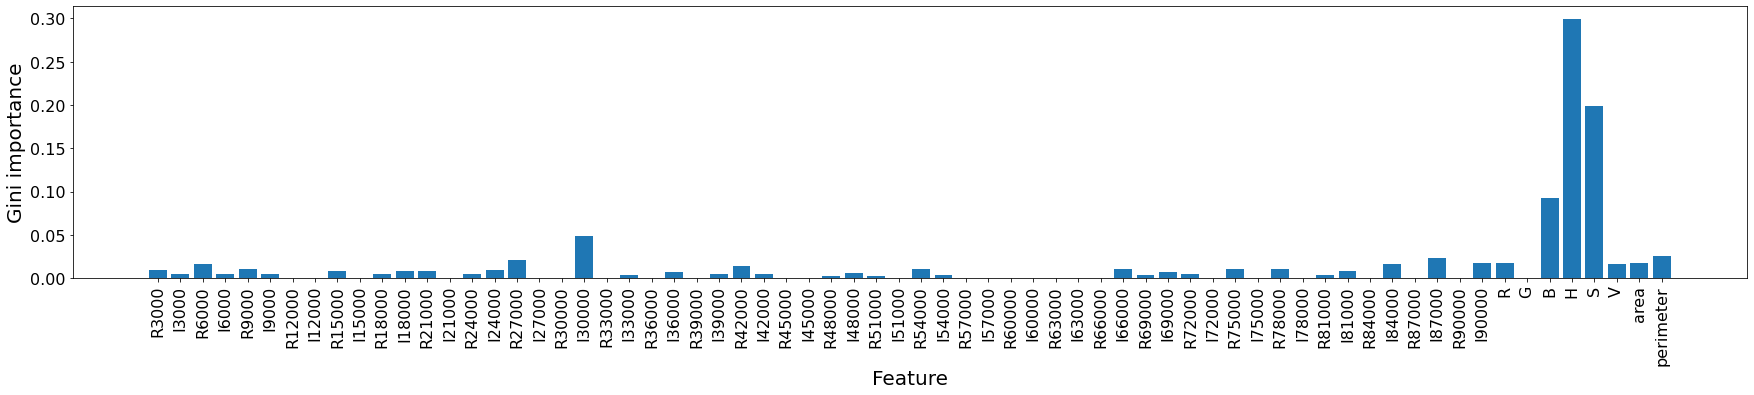

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 5, 'model__n_estimators': 3}
[INFO] Best score: 0.8974
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 27
Feature importances via feature_importances_ for Random Forest


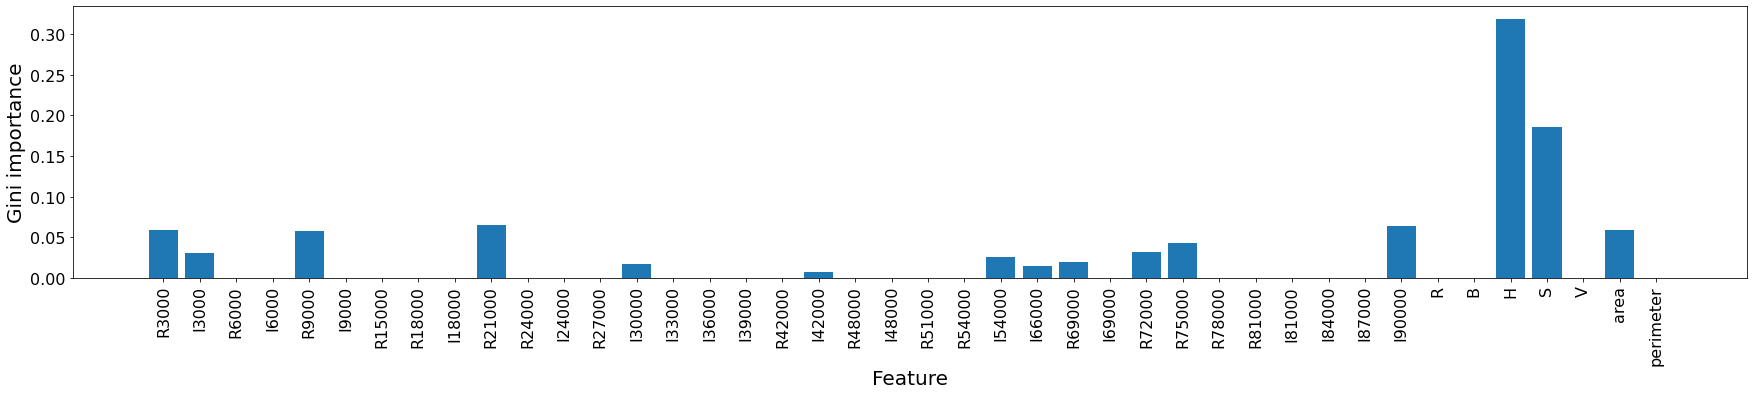

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 3, 'model__n_estimators': 5}
[INFO] Best score: 0.9487
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 5
Feature importances via feature_importances_ for Random Forest


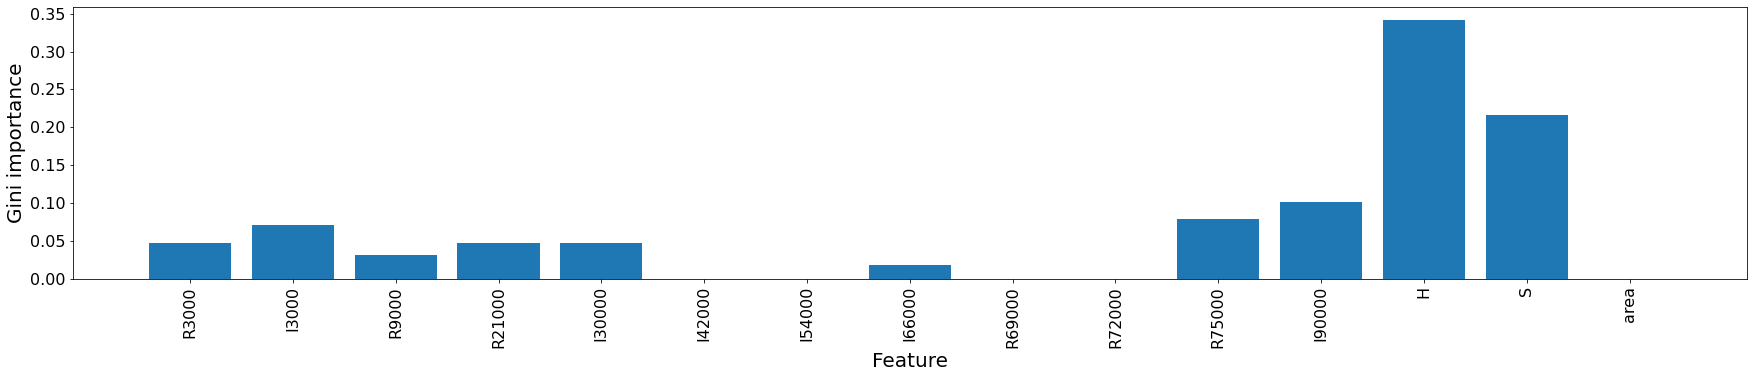

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 6, 'model__n_estimators': 5}
[INFO] Best score: 0.9103
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 0
[INFO] Inputs can not be further reduced!
Feature importances via feature_importances_ for Random Forest


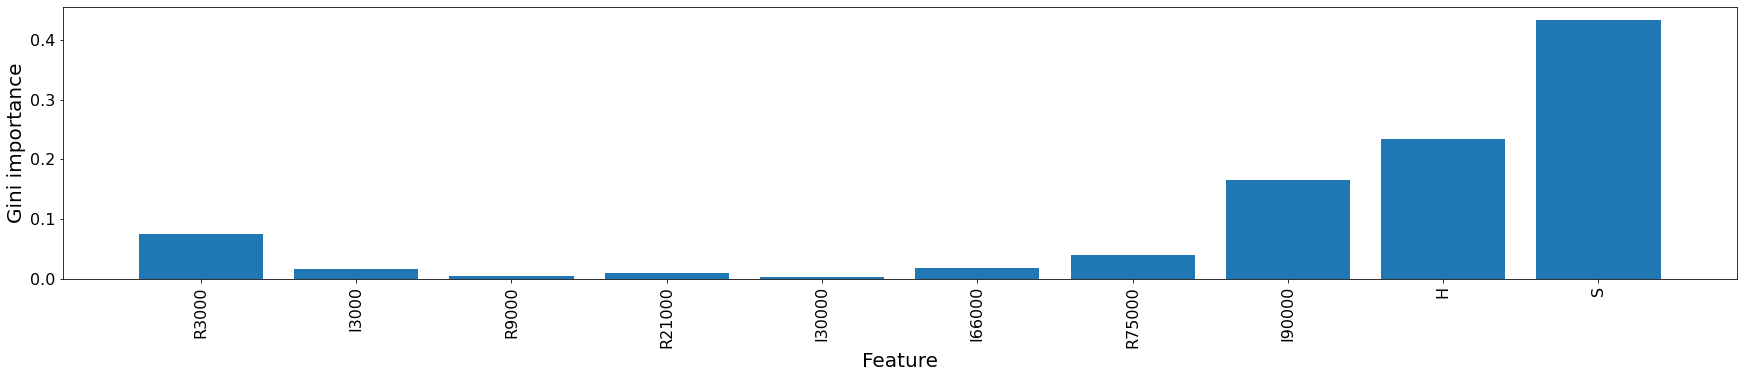

[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model
[INFO] Best parameter: {'model__max_features': 6, 'model__n_estimators': 5}
[INFO] Best score: 0.9103
[[33  4]
 [ 0 13]]
F1 score	Purity		Recovery
0.8667		0.7647		1.0




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File uploaded: Aluminium_8-25WF_ffs_dataset.csv
[INFO] Number of CV folds: StratifiedKFold(n_splits=23, random_state=None, shuffle=False)
[INFO] Number of max features: 34
[INFO] N_estimators combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[INFO] max_feature combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 29, 'model__n_estimators': 13}
[INFO] Best score: 0.9275
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 30
Feature importances via feature_importances_ for Random Forest


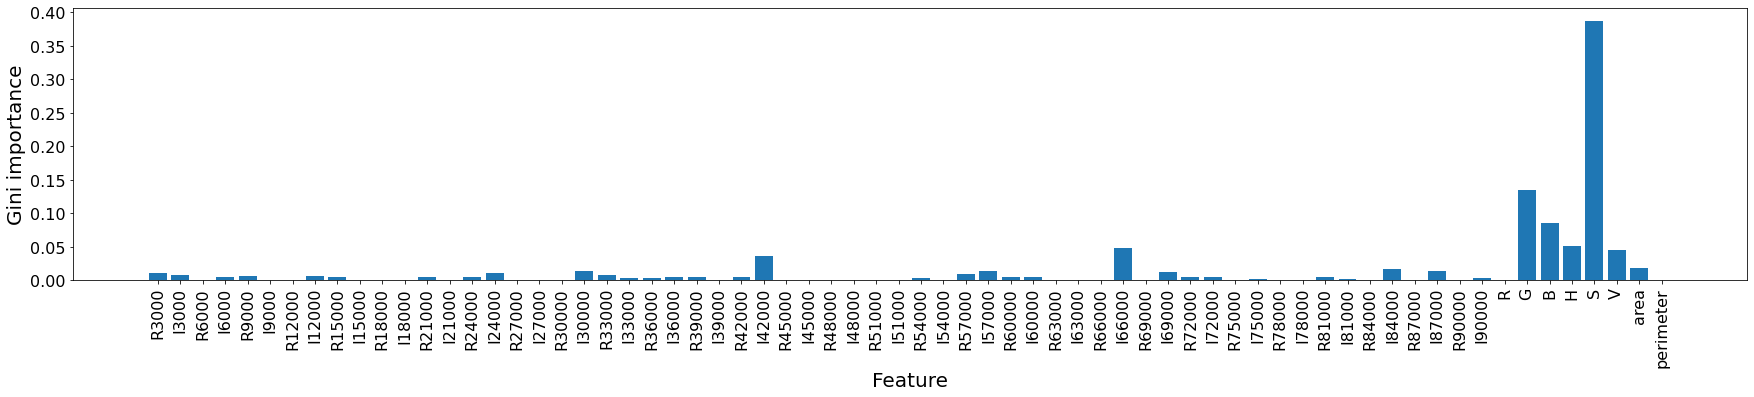

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 15, 'model__n_estimators': 13}
[INFO] Best score: 0.9275
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 8
Feature importances via feature_importances_ for Random Forest


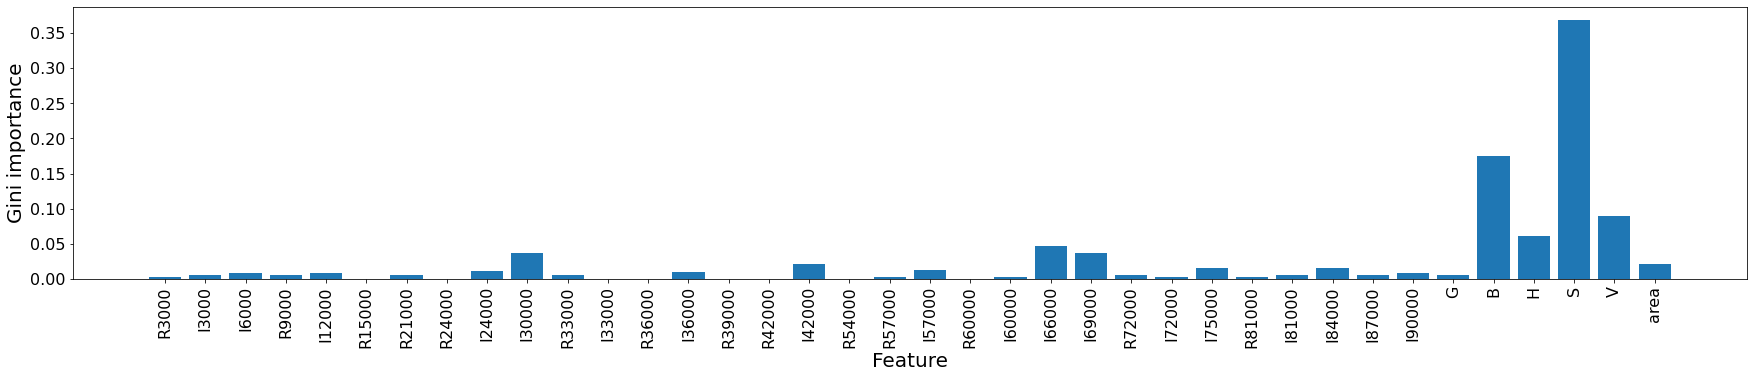

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 5, 'model__n_estimators': 17}
[INFO] Best score: 0.9275
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 3
Feature importances via feature_importances_ for Random Forest


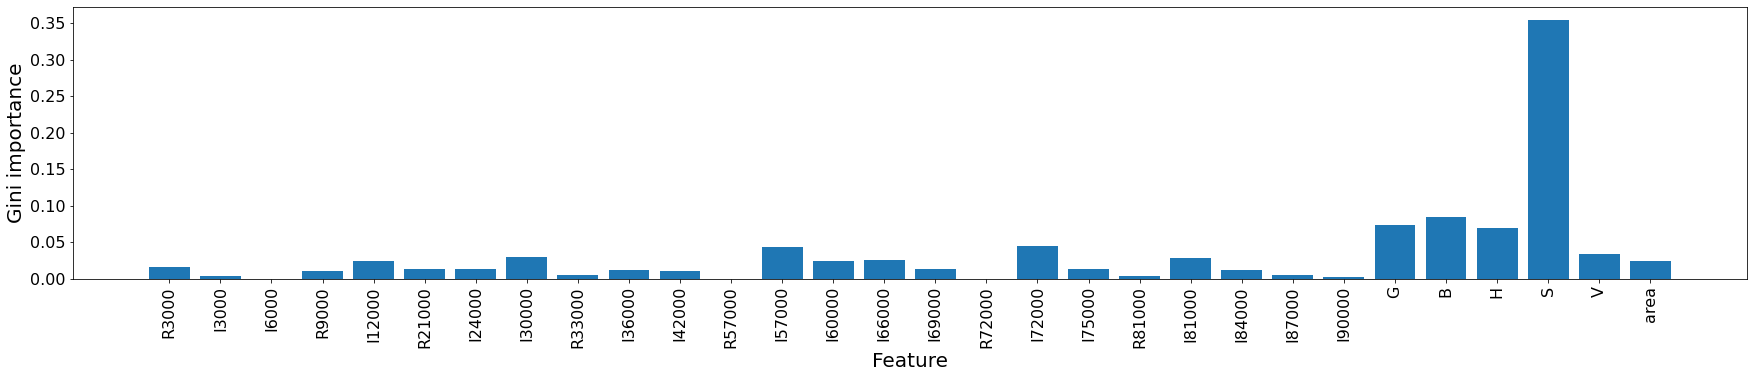

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 4, 'model__n_estimators': 3}
[INFO] Best score: 0.9275
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 13
Feature importances via feature_importances_ for Random Forest


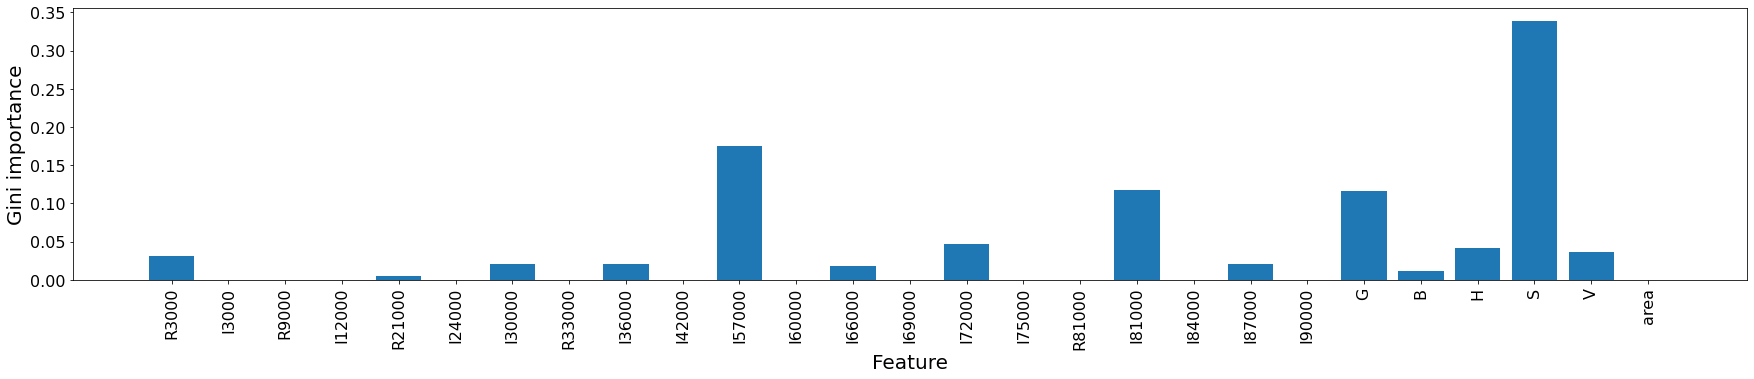

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 3, 'model__n_estimators': 7}
[INFO] Best score: 0.9275
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 0
[INFO] Inputs can not be further reduced!
Feature importances via feature_importances_ for Random Forest


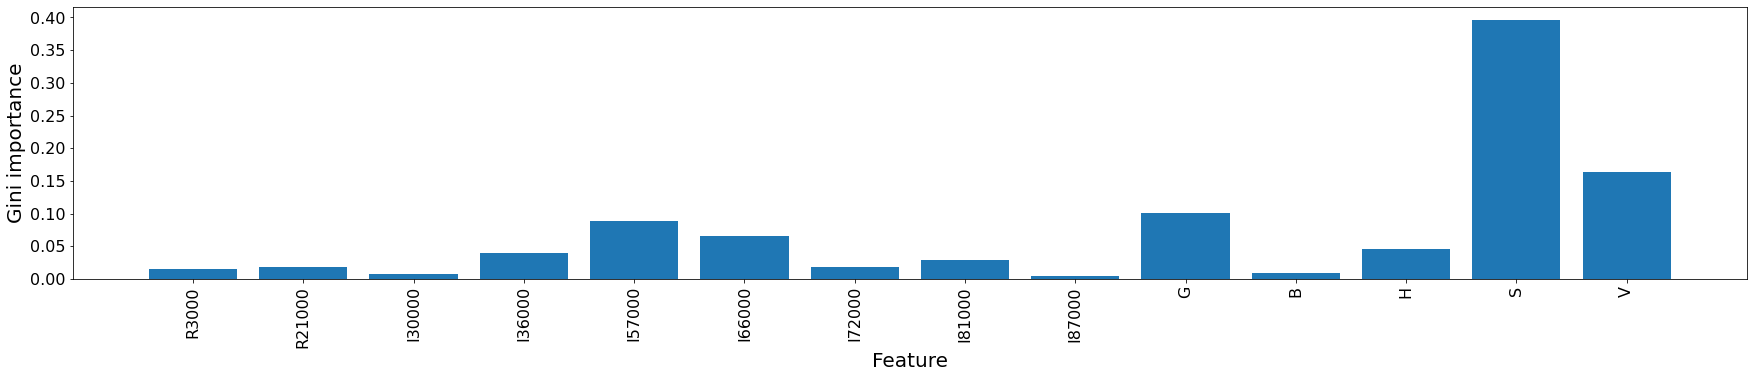

[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model
[INFO] Best parameter: {'model__max_features': 3, 'model__n_estimators': 7}
[INFO] Best score: 0.9275
[[21  2]
 [ 1 25]]
F1 score	Purity		Recovery
0.9434		0.9259		0.9615




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File uploaded: Aluminium_25-75WF_dataset.csv
[INFO] Number of CV folds: StratifiedKFold(n_splits=13, random_state=None, shuffle=False)
[INFO] Number of max features: 34
[INFO] N_estimators combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[INFO] max_feature combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 1, 'model__n_estimators': 9}
[INFO] Best score: 0.7179
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 21
Feature importances via feature_importances_ for Random Forest


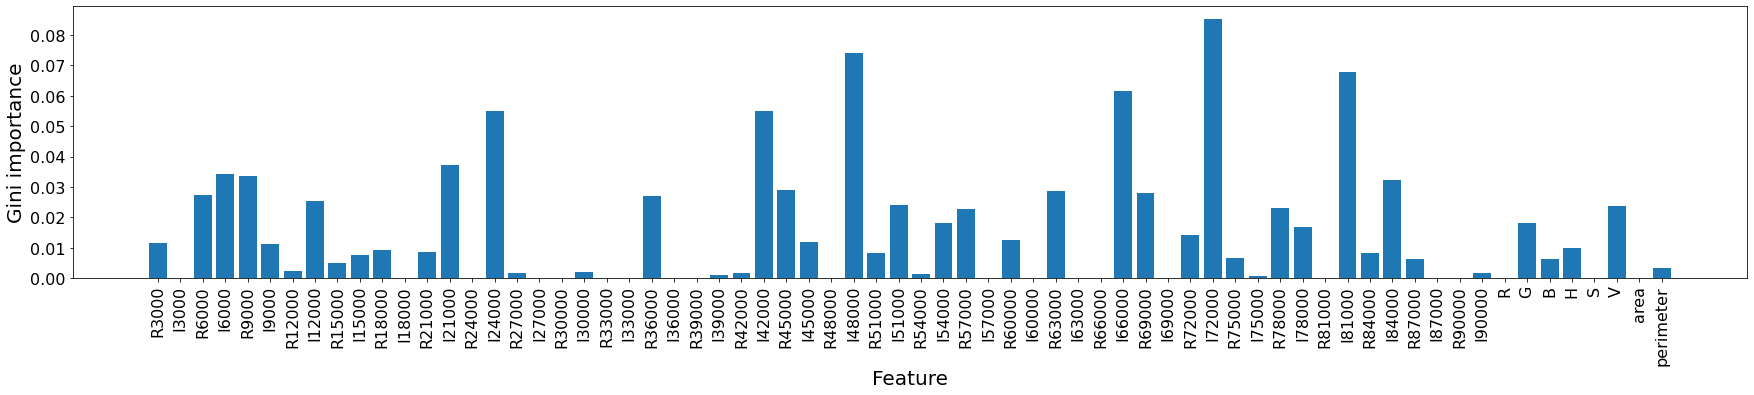

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 2, 'model__n_estimators': 2}
[INFO] Best score: 0.8205
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 36
Feature importances via feature_importances_ for Random Forest


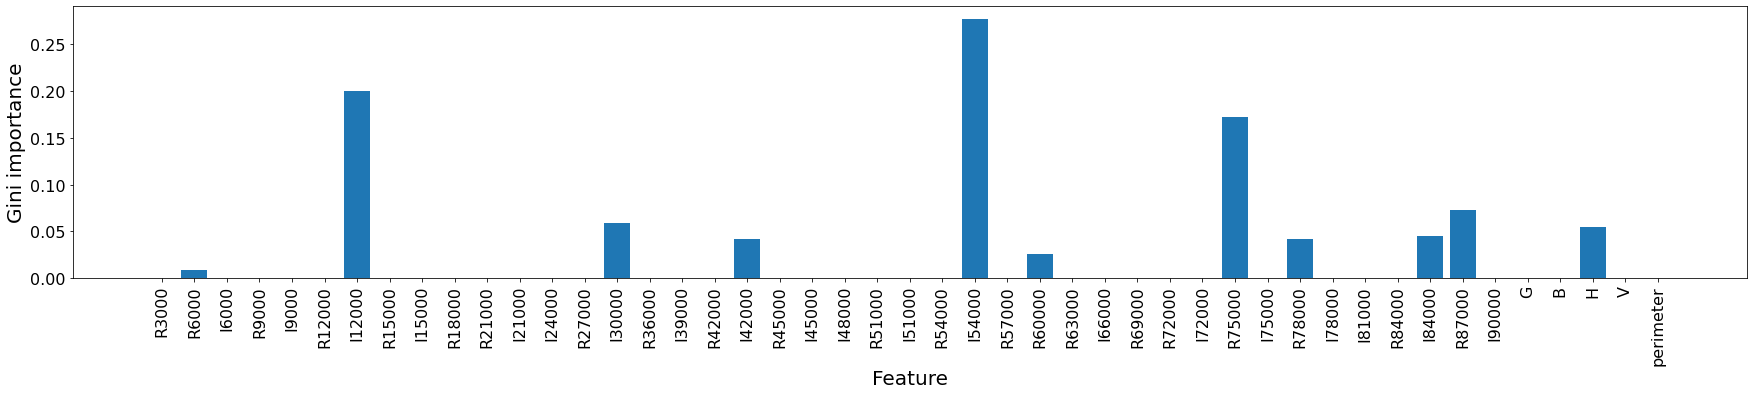

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 5, 'model__n_estimators': 1}
[INFO] Best score: 0.7949
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 6
Feature importances via feature_importances_ for Random Forest


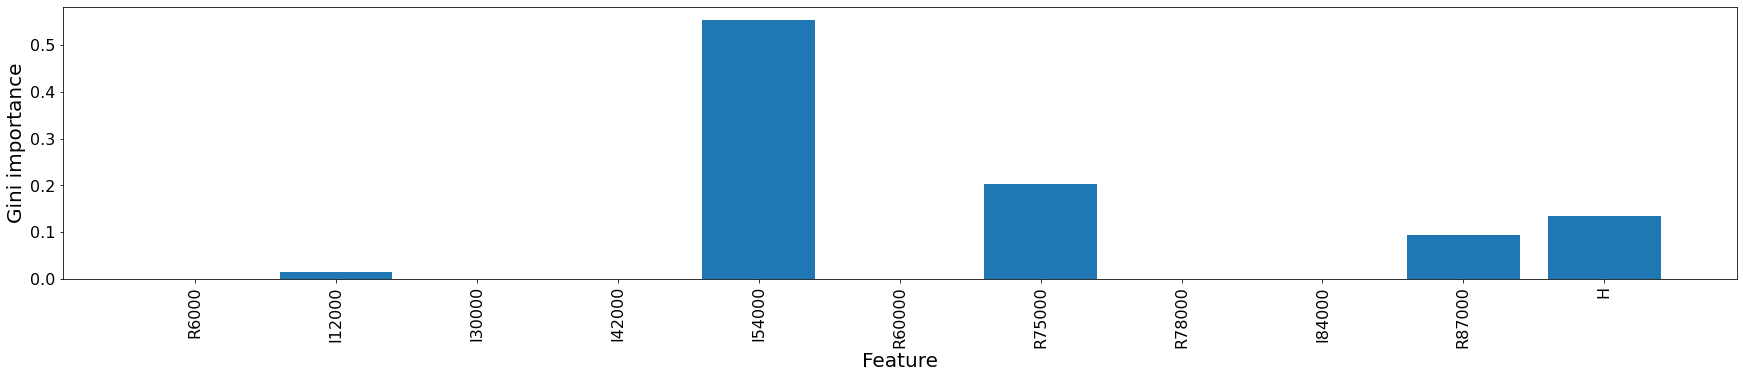

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 1, 'model__n_estimators': 18}
[INFO] Best score: 0.8205
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 0
[INFO] Inputs can not be further reduced!
Feature importances via feature_importances_ for Random Forest


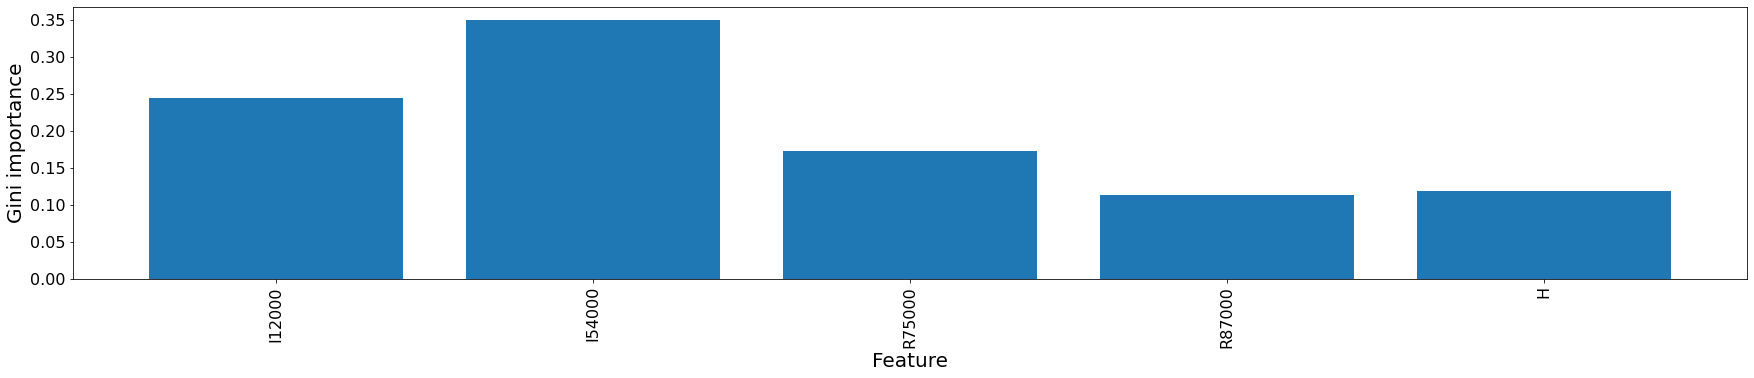

[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model
[INFO] Best parameter: {'model__max_features': 1, 'model__n_estimators': 18}
[INFO] Best score: 0.8205
[[27  1]
 [ 2 11]]
F1 score	Purity		Recovery
0.88		0.9167		0.8462




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File uploaded: Aluminium_FM_dataset.csv
[INFO] Number of CV folds: StratifiedKFold(n_splits=19, random_state=None, shuffle=False)
[INFO] Number of max features: 34
[INFO] N_estimators combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[INFO] max_feature combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 12, 'model__n_estimators': 1}
[INFO] Best score: 0.9825
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 64
Feature importances via feature_importances_ for Random Forest


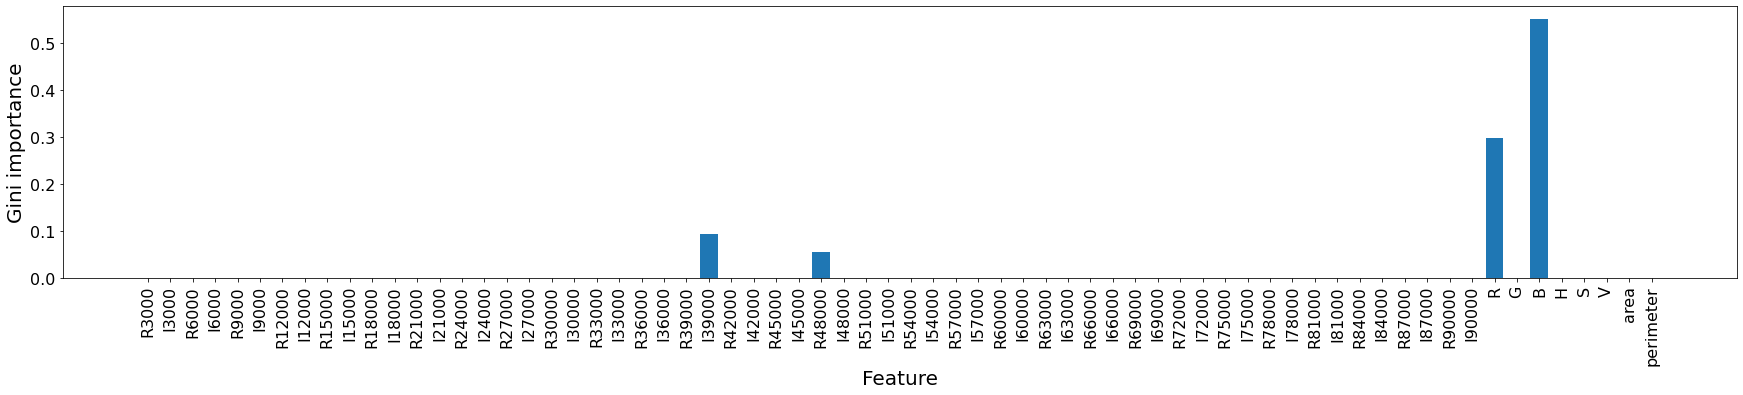

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 4, 'model__n_estimators': 1}
[INFO] Best score: 0.9825
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 1
Feature importances via feature_importances_ for Random Forest


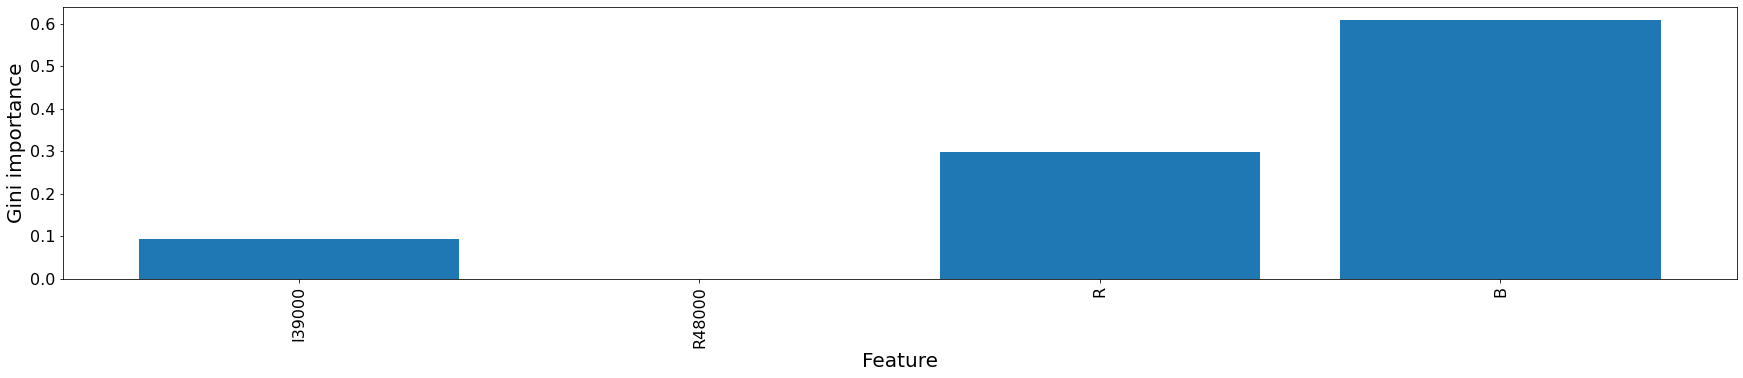

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 2, 'model__n_estimators': 2}
[INFO] Best score: 0.9649
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 0
[INFO] Inputs can not be further reduced!
Feature importances via feature_importances_ for Random Forest


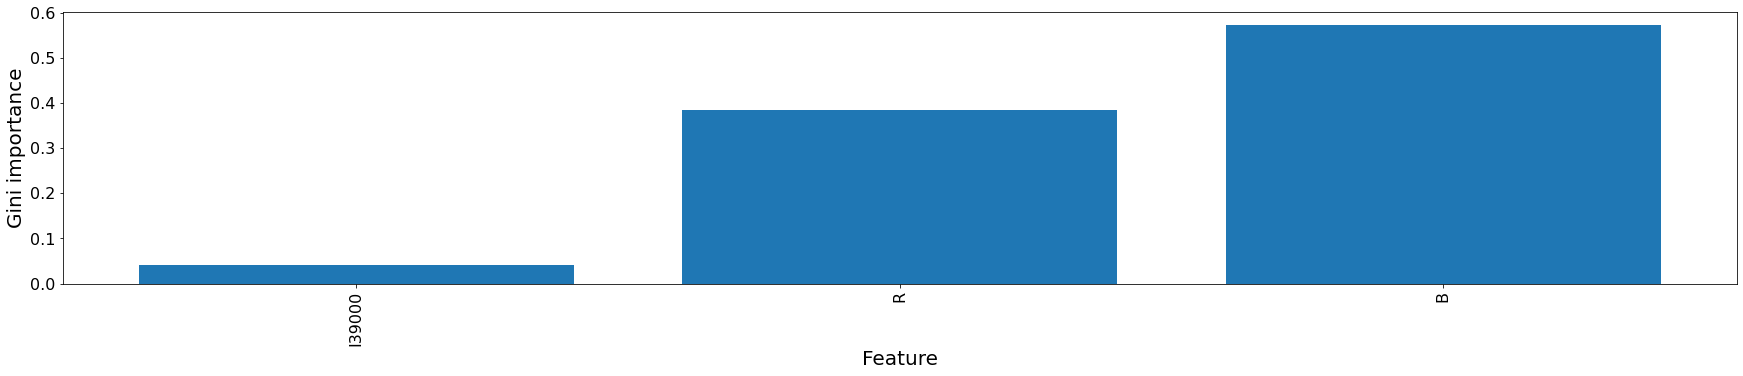

[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model
[INFO] Best parameter: {'model__max_features': 2, 'model__n_estimators': 2}
[INFO] Best score: 0.9649
[[19  0]
 [ 2 29]]
F1 score	Purity		Recovery
0.9667		1.0		0.9355




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File uploaded: Brass_3-8Zor_ffs_dataset.csv
[INFO] Number of CV folds: StratifiedKFold(n_splits=18, random_state=None, shuffle=False)
[INFO] Number of max features: 34
[INFO] N_estimators combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[INFO] max_feature combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 30, 'model__n_estimators': 1}
[INFO] Best score: 0.7407
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 62
Feature importances via feature_importances_ for Random Forest


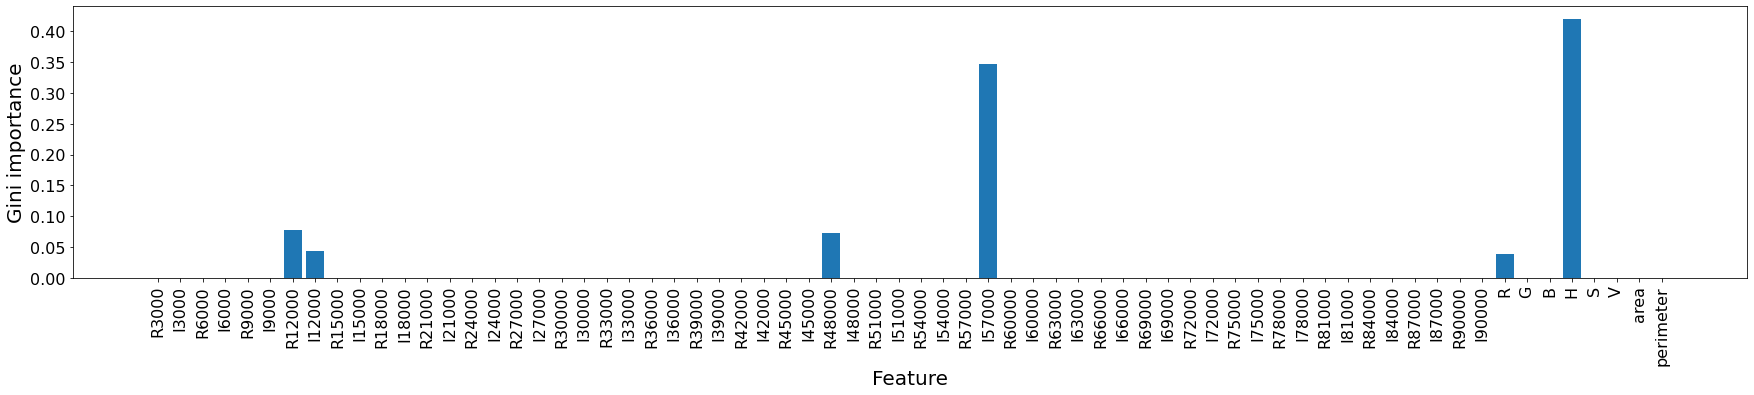

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 4, 'model__n_estimators': 3}
[INFO] Best score: 0.7593
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 0
[INFO] Inputs can not be further reduced!
Feature importances via feature_importances_ for Random Forest


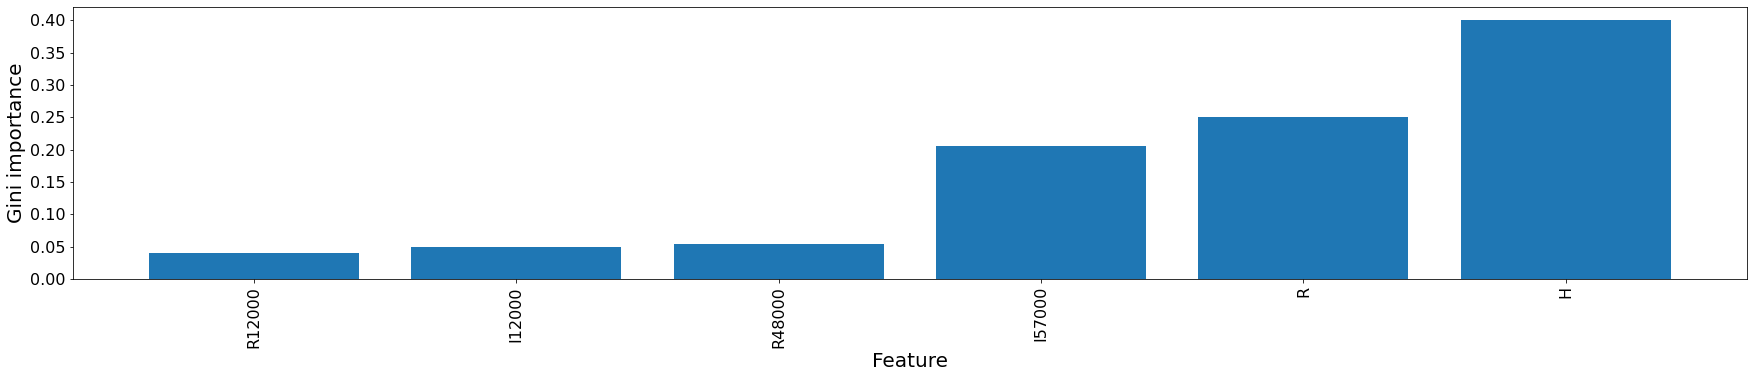

[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model
[INFO] Best parameter: {'model__max_features': 4, 'model__n_estimators': 3}
[INFO] Best score: 0.7593
[[27  5]
 [ 3 15]]
F1 score	Purity		Recovery
0.7895		0.75		0.8333




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File uploaded: Brass_BIM_dataset.csv
[INFO] Number of CV folds: StratifiedKFold(n_splits=17, random_state=None, shuffle=False)
[INFO] Number of max features: 34
[INFO] N_estimators combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[INFO] max_feature combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 20, 'model__n_estimators': 8}
[INFO] Best score: 0.8569
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 23
Feature importances via feature_importances_ for Random Forest


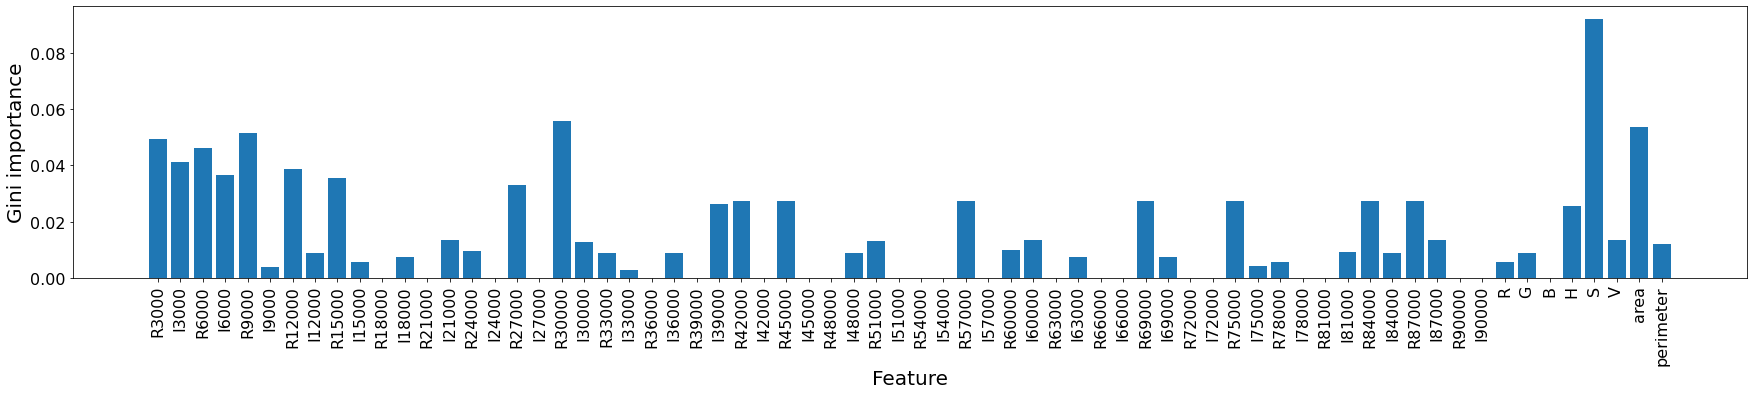

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 11, 'model__n_estimators': 15}
[INFO] Best score: 0.8569
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 4
Feature importances via feature_importances_ for Random Forest


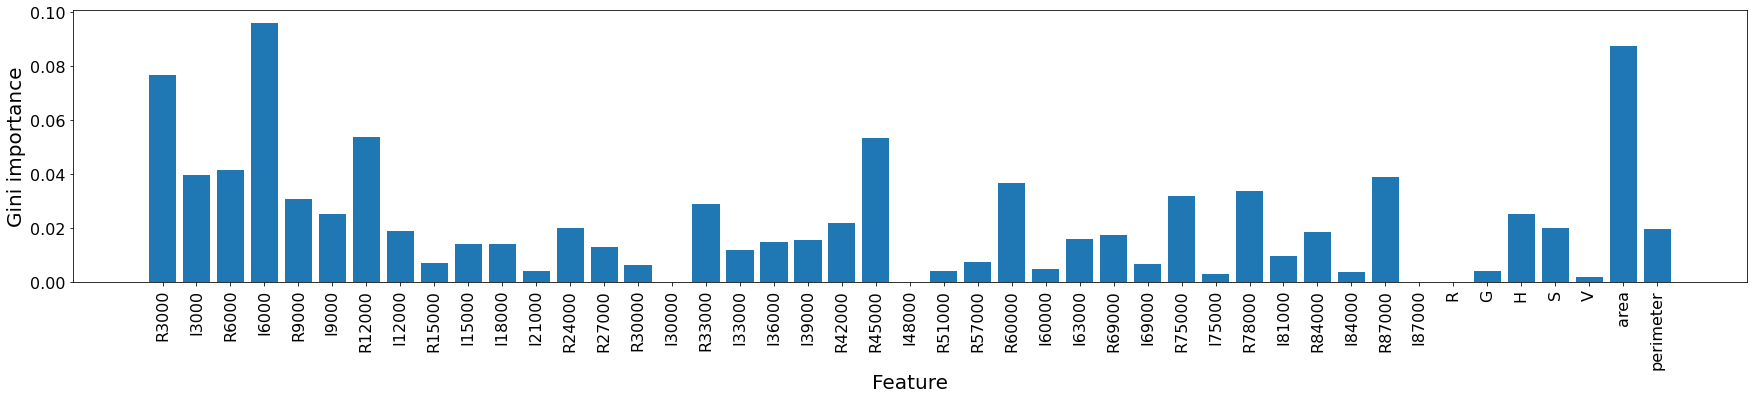

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 26, 'model__n_estimators': 1}
[INFO] Best score: 0.8608
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 32
Feature importances via feature_importances_ for Random Forest


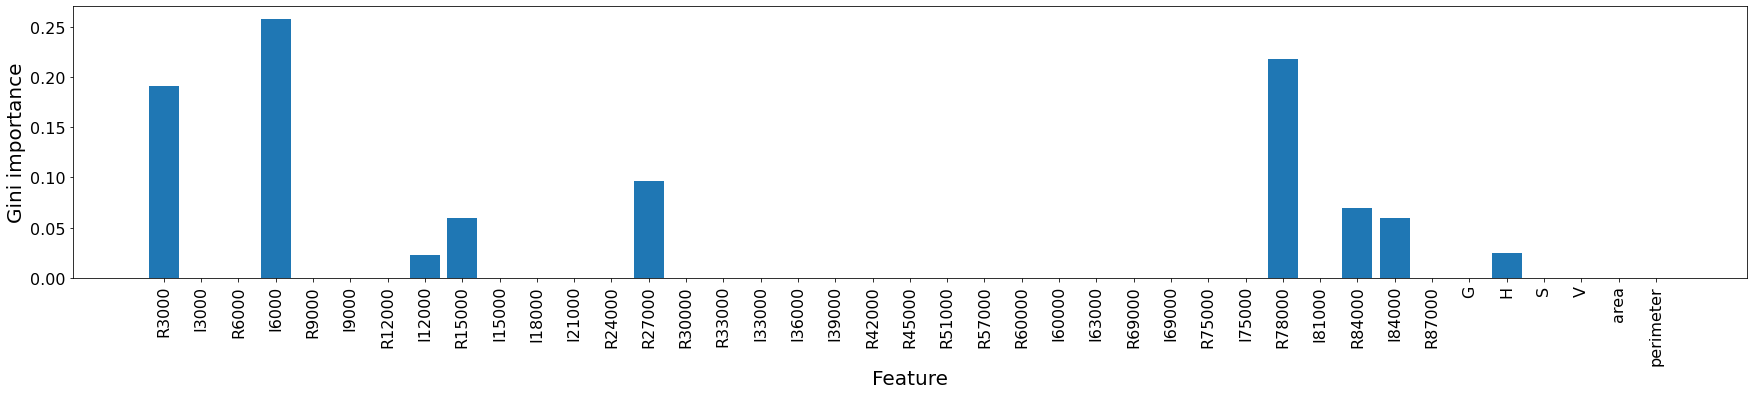

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 4, 'model__n_estimators': 1}
[INFO] Best score: 0.8902
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 2
Feature importances via feature_importances_ for Random Forest


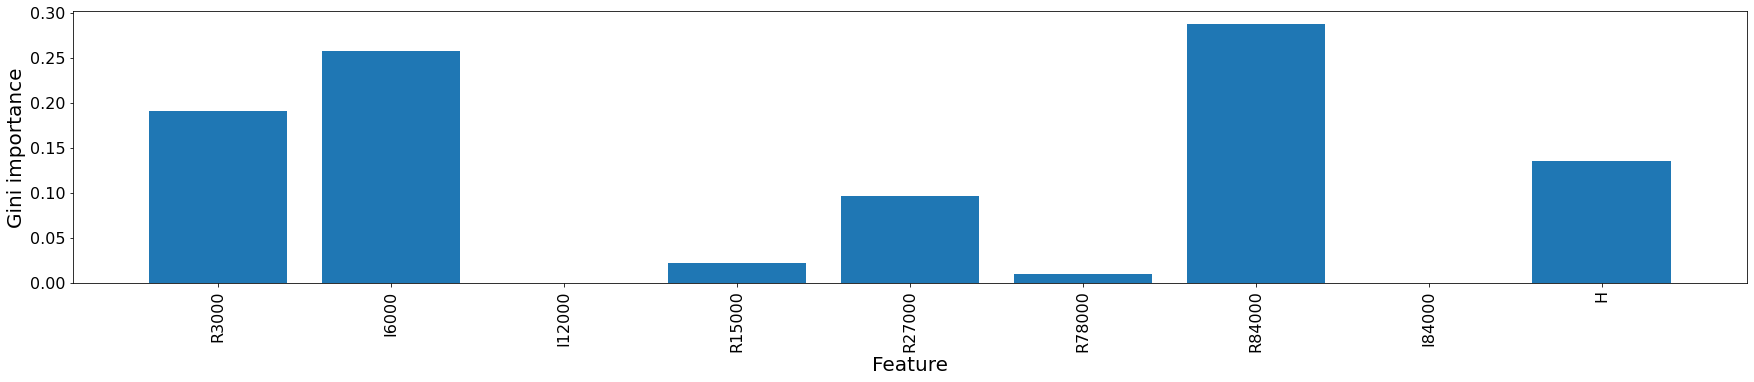

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 2, 'model__n_estimators': 12}
[INFO] Best score: 0.8353
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 0
[INFO] Inputs can not be further reduced!
Feature importances via feature_importances_ for Random Forest


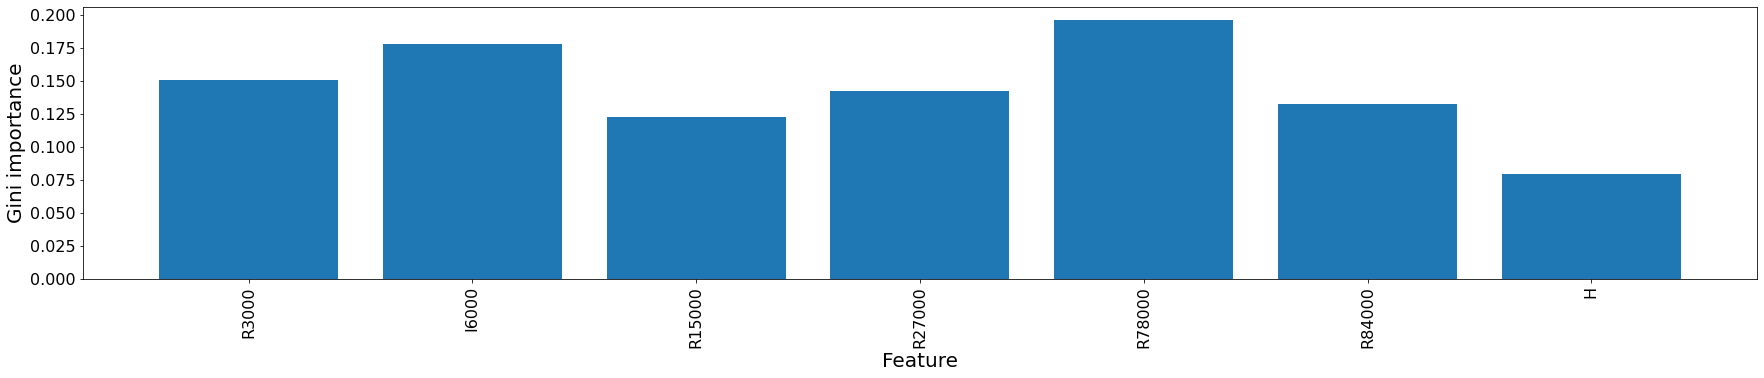

[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model
[INFO] Best parameter: {'model__max_features': 2, 'model__n_estimators': 12}
[INFO] Best score: 0.8353
[[10  7]
 [ 4 28]]
F1 score	Purity		Recovery
0.8358		0.8		0.875




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File uploaded: SSteel_8-25Zur_datset.csv
[INFO] Number of CV folds: StratifiedKFold(n_splits=17, random_state=None, shuffle=False)
[INFO] Number of max features: 34
[INFO] N_estimators combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[INFO] max_feature combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 18, 'model__n_estimators': 13}
[INFO] Best score: 0.9765
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 32
Feature importances via feature_importances_ for Random Forest


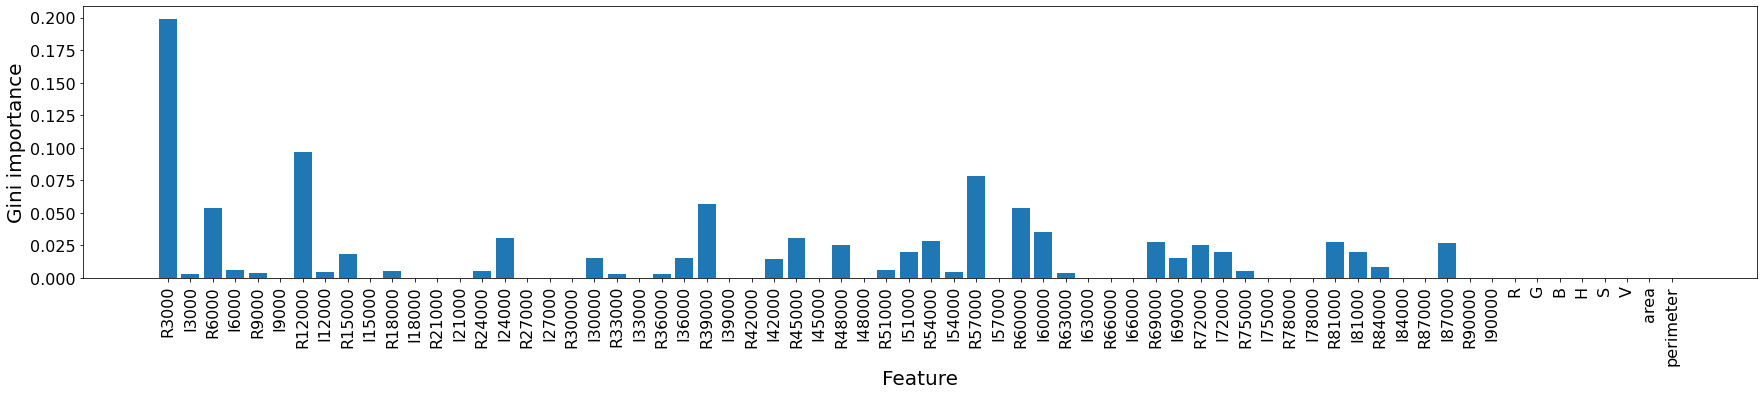

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 19, 'model__n_estimators': 1}
[INFO] Best score: 0.9882
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 32
Feature importances via feature_importances_ for Random Forest


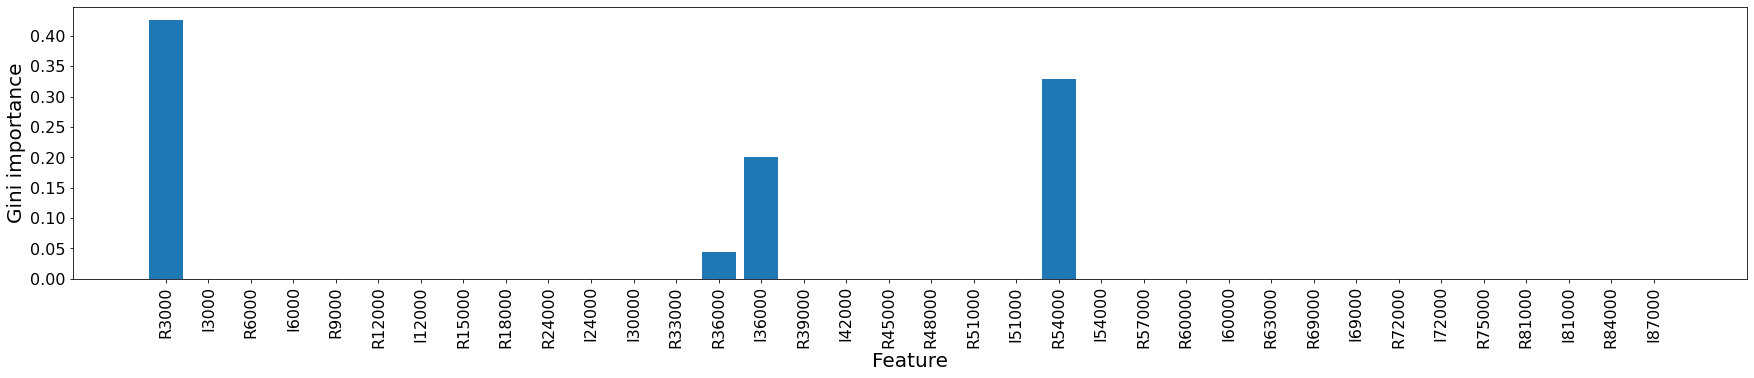

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 2, 'model__n_estimators': 3}
[INFO] Best score: 0.9882
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 0
[INFO] Inputs can not be further reduced!
Feature importances via feature_importances_ for Random Forest


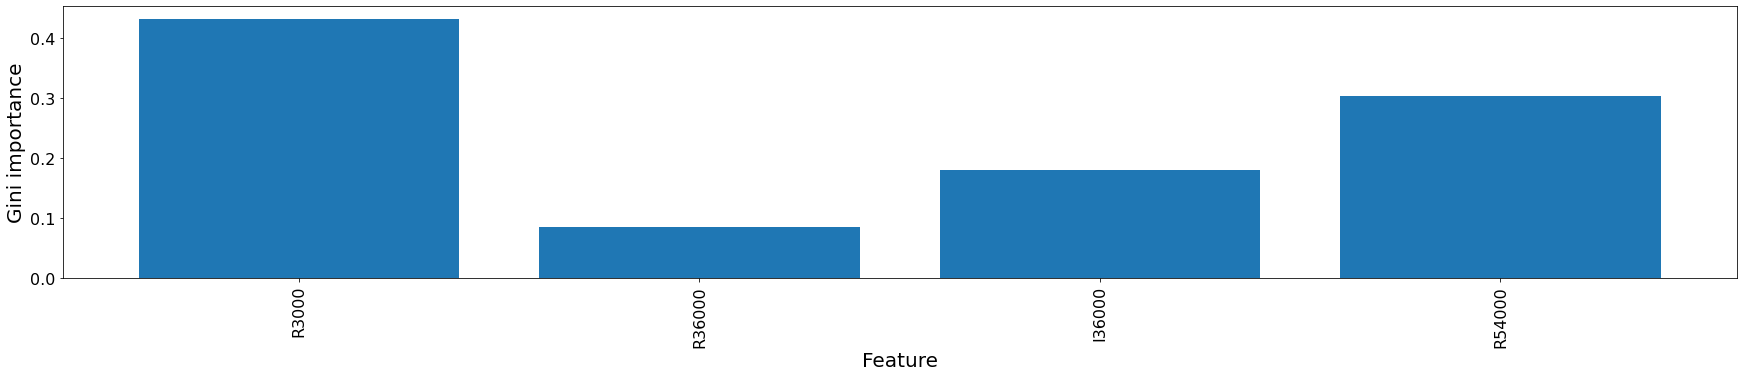

[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model
[INFO] Best parameter: {'model__max_features': 2, 'model__n_estimators': 3}
[INFO] Best score: 0.9882
[[16  1]
 [ 0 33]]
F1 score	Purity		Recovery
0.9851		0.9706		1.0




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File uploaded: SSteel_25-75WF_dataset.csv
[INFO] Number of CV folds: StratifiedKFold(n_splits=14, random_state=None, shuffle=False)
[INFO] Number of max features: 34
[INFO] N_estimators combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[INFO] max_feature combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 2, 'model__n_estimators': 19}
[INFO] Best score: 1.0
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 19
Feature importances via feature_importances_ for Random Forest


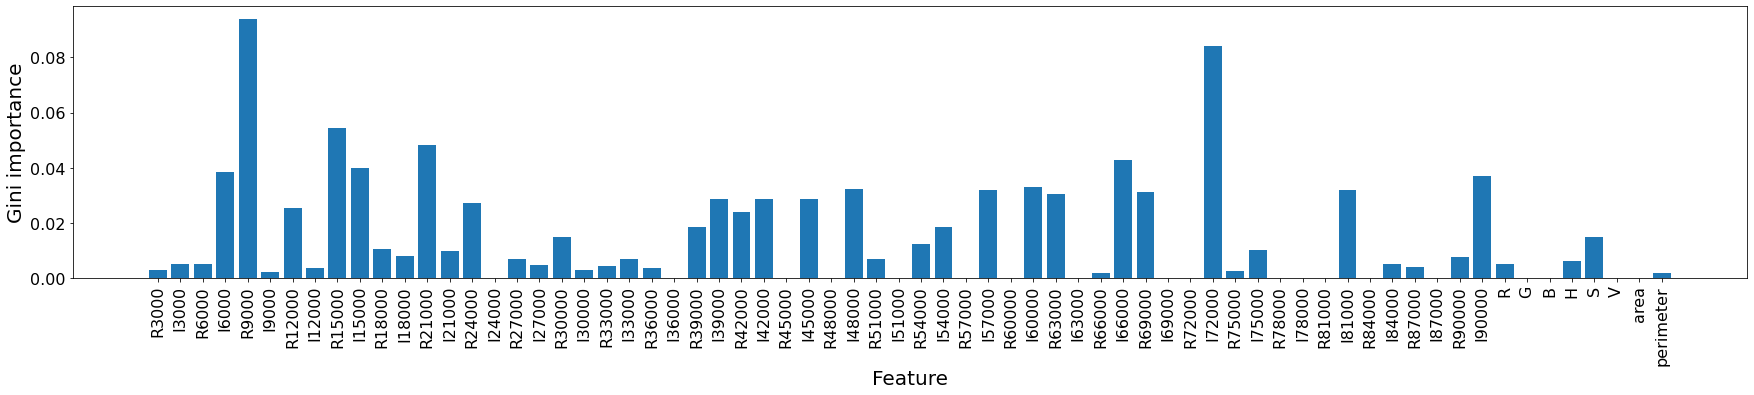

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 1, 'model__n_estimators': 10}
[INFO] Best score: 1.0
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 19
Feature importances via feature_importances_ for Random Forest


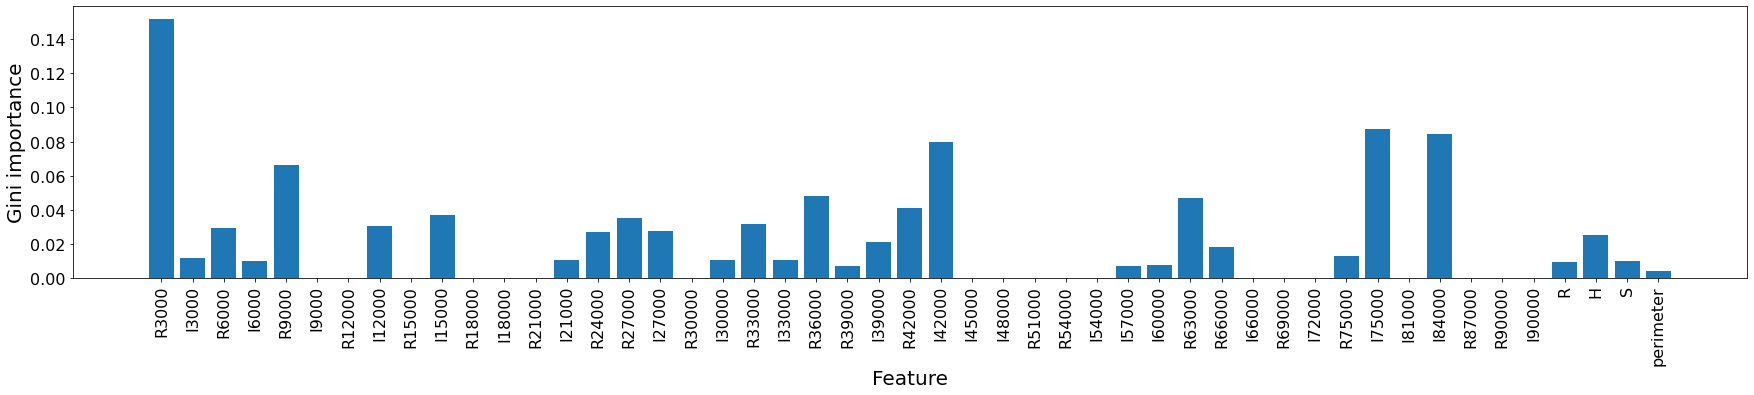

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 1, 'model__n_estimators': 7}
[INFO] Best score: 1.0
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 7
Feature importances via feature_importances_ for Random Forest


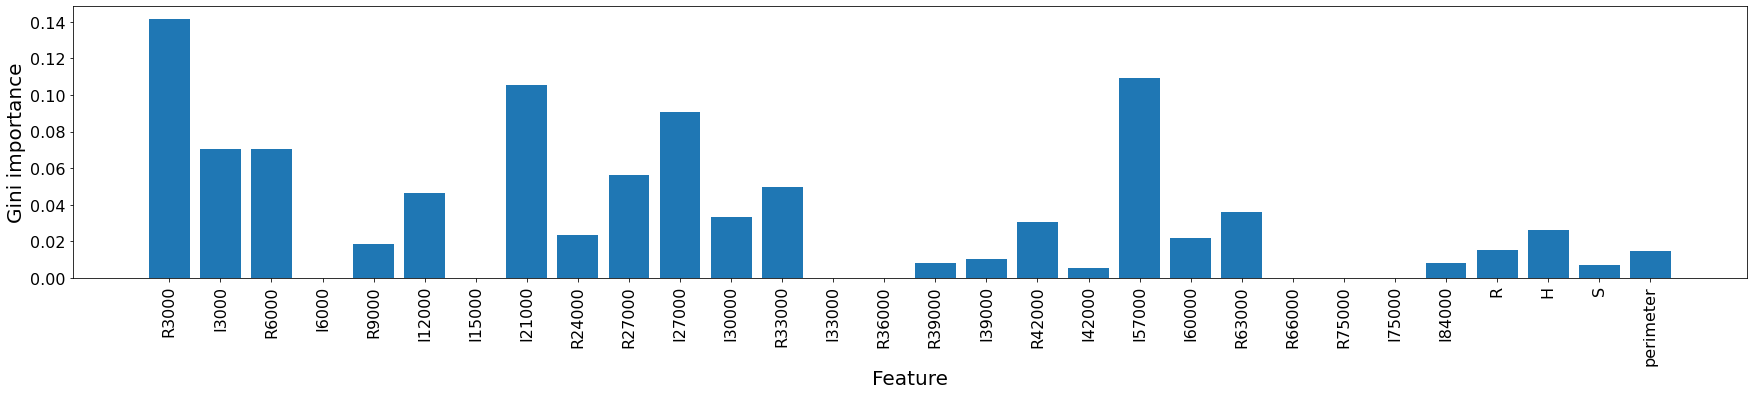

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 1, 'model__n_estimators': 6}
[INFO] Best score: 1.0
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 8
Feature importances via feature_importances_ for Random Forest


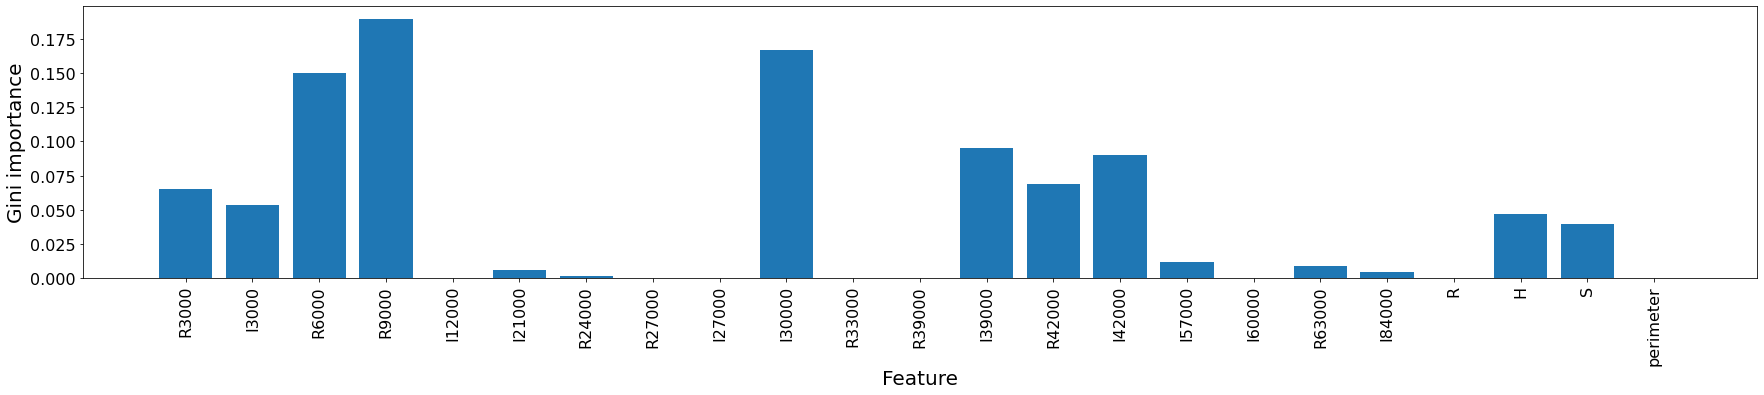

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 1, 'model__n_estimators': 2}
[INFO] Best score: 1.0
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 7
Feature importances via feature_importances_ for Random Forest


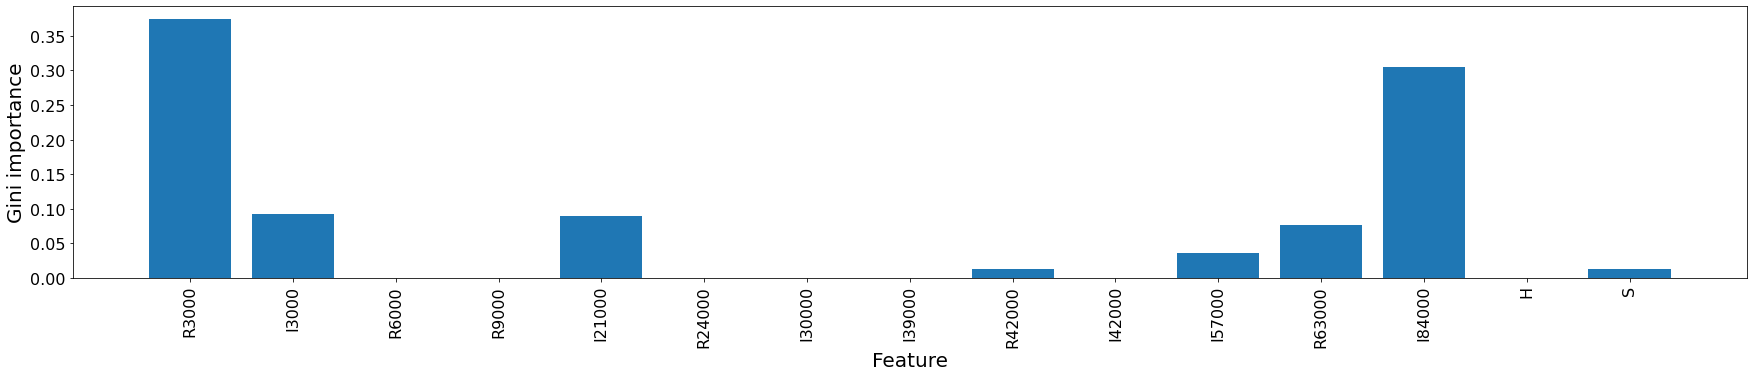

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 1, 'model__n_estimators': 12}
[INFO] Best score: 1.0
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 0
[INFO] Inputs can not be further reduced!
Feature importances via feature_importances_ for Random Forest


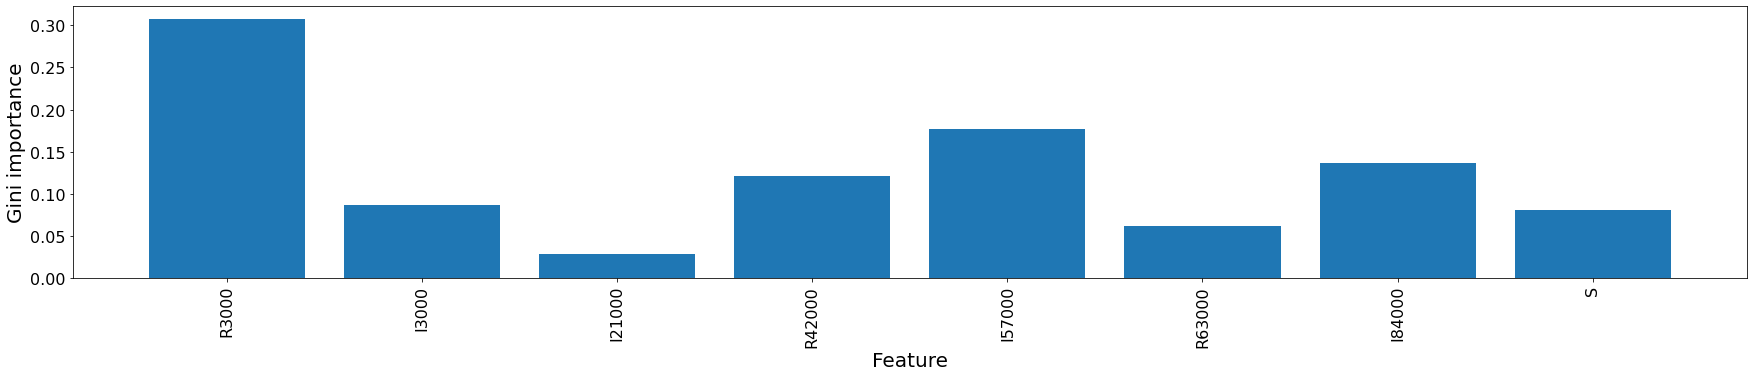

[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model
[INFO] Best parameter: {'model__max_features': 1, 'model__n_estimators': 12}
[INFO] Best score: 1.0
[[27  0]
 [ 0 14]]
F1 score	Purity		Recovery
1.0		1.0		1.0




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File uploaded: Zinc_8-25WF_ffs_dataset.csv
[INFO] Number of CV folds: StratifiedKFold(n_splits=21, random_state=None, shuffle=False)
[INFO] Number of max features: 34
[INFO] N_estimators combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[INFO] max_feature combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 34, 'model__n_estimators': 5}
[INFO] Best score: 0.8571
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 48
Feature importances via feature_importances_ for Random Forest


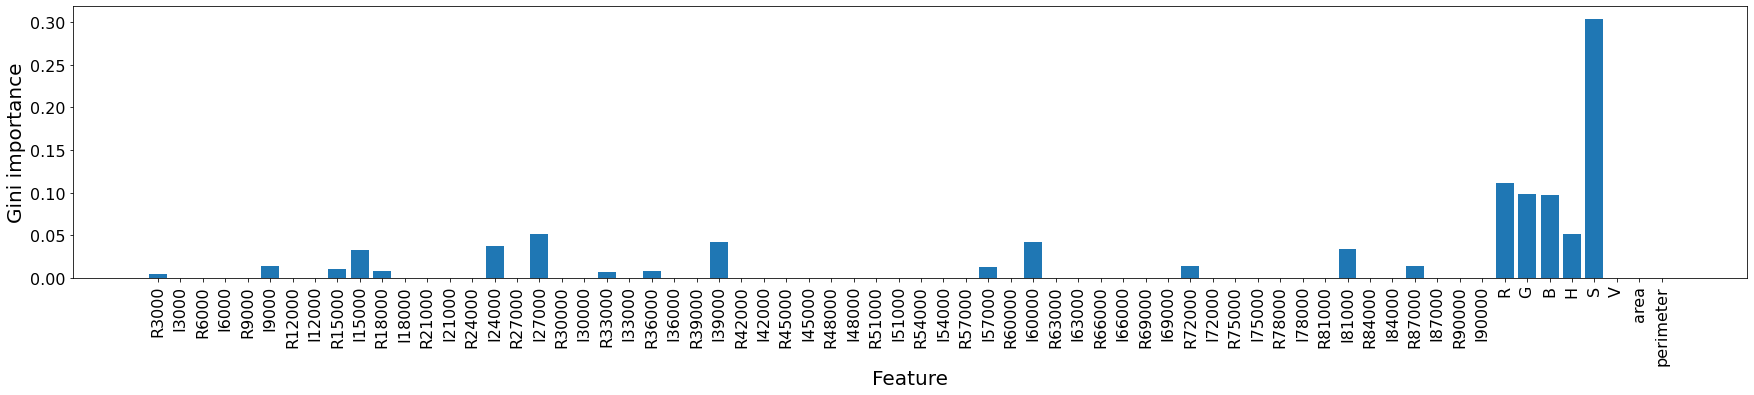

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 5, 'model__n_estimators': 12}
[INFO] Best score: 0.873
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 0
[INFO] Inputs can not be further reduced!
Feature importances via feature_importances_ for Random Forest


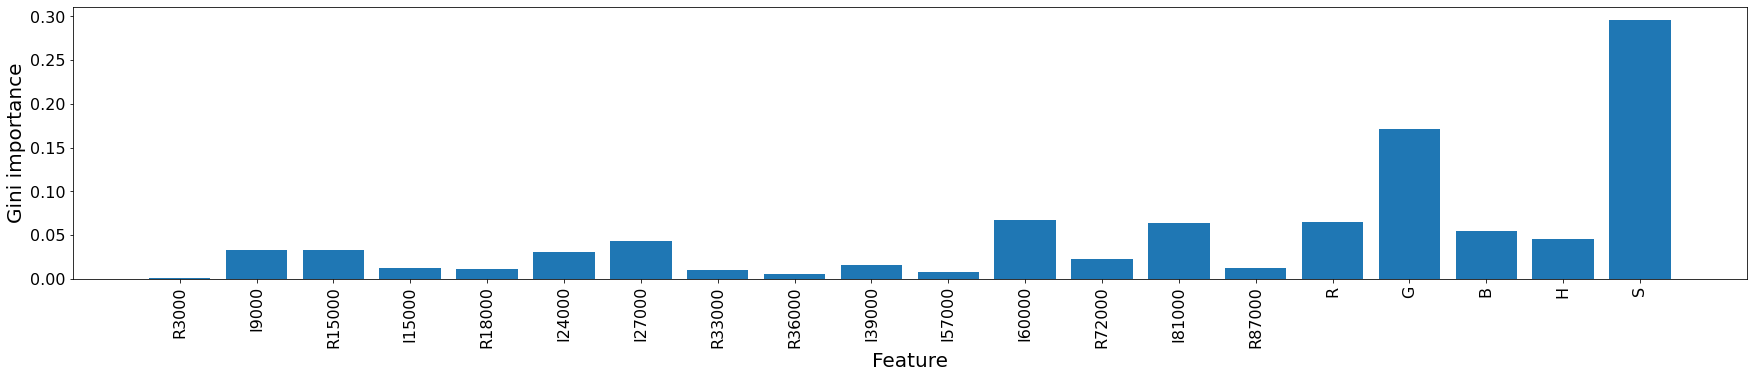

[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model
[INFO] Best parameter: {'model__max_features': 5, 'model__n_estimators': 12}
[INFO] Best score: 0.873
[[25  3]
 [ 2 19]]
F1 score	Purity		Recovery
0.8837		0.8636		0.9048




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Create lists
best_results = []
model_check = []
best_features = []
print("[INFO] CODE START")

#loop through all files that are uploaded
for key in uploaded:
    best_model_list = []  
    best_features = []
    reduction_mode = False

    print("File uploaded: " +str(key))
    #Convert the loaded csv file to a pandas dataframe
    loaded_file = pd.read_csv(io.BytesIO(uploaded[key]))

    #create the x and y train datasets
    x_train_df = loaded_file.drop(['Label'], axis='columns')
    x_train = x_train_df.copy()
    y_train = loaded_file.Label

    #calcualte the largest possible cross validation
    number_of_cv_folds = StratifiedKFold(calculate_cross_validation_value(y_train))
    print("[INFO] Number of CV folds: " + str(number_of_cv_folds))

    #Calualte the all feature combinations and create list for vaible combinations
    max_featutures_var, n_estitmators_var = testing_combination_arrays(x_train, 20)
    print("[INFO] N_estimators combinations: " + str(n_estitmators_var))
    print("[INFO] max_feature combinations: " + str(max_featutures_var))

    #While te input features is being reduced
    while(reduction_mode==False):

      #Perform grid search for Random Forest 
      print("[INFO] Finding best model parameters with reduced x_train")
      best_model_details, best_paramater = grid_search_RF_function(x_train, y_train, n_estitmators_var, max_featutures_var, number_of_cv_folds)

      #append the models best details to a list
      best_model_list.append(best_model_details)

      #Reduce the input data and append the results
      print("[INFO] Reducing input data based on best model")
      reduction_mode, x_train, x_train_df = reduce_input(x_train, y_train, number_of_cv_folds, best_paramater, x_train_df)
      best_features.append(x_train_df.columns)

    #If the inputs can be no longer reduced do a final grid search to aquire the best parameters
    print("[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model")
    best_model_details, best_paramater = grid_search_RF_function(x_train, y_train, n_estitmators_var, max_featutures_var, number_of_cv_folds)

    best_model_list.append(best_model_details)

    #check the model again with cross vaildation to obtain all the accuracies
    model_check = best_model_test(x_train, y_train, number_of_cv_folds, best_paramater, best_results, x_train_df)
    
    #Save the results a .CSV file
    with open(str(key) + '_random_forest' +  '.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerows(best_model_list)
        writer.writerow(model_check_header)
        writer.writerows(model_check)
        writer.writerow(best_features_header)
        writer.writerows(best_features)

    files.download(str(key) + '_random_forest' + '.csv') 
